# Tarea 1 <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Mario Vicuña Álvarez
Fecha para completar la tarea: miercoles 25 de abril de 2018


## Insturcciones:
En este notebook debes dejar todo tu código de las partes 1 hasta 8 de la tarea. Debes dejar el código (y todo lo adicional que hayas programado) en las celdas designadas para ello. Las partes que se hacen a mano (o con fórmulas), puedes entregarlas al final o en un archivo separado. En la siguiente celda encontrarás un *check list* de las partes de la tarea. En cada item indica si lo completaste o no en tu entrega ('SI', o 'NO'). Por favor, no marques como 'SI' partes que no hiciste. Adicionalemnte, el lugar en tu código donde completaste cada parte, márcala con un comentario como el siguiente

```
#### Parte 4a) Método backward
```

Si bien para algunas partes puede no estar exactamente claro dónde comienza (y termina) cada parte, usa tu criterio para los comentarios. Esto es sólo para ayudarnos a corregir. Nota que las celdas de más abajo no necesariamente siguen el orden del check list. Por ejemplo en la celda donde defines tu clase para la red neuronal se espera agregues código de las partes 2, 3, 7 etc. Todo eso está en una única celda (lo entenderás cuando mires más abajo).

Por favor sigue este formato. **Si no sigues el formato te descontaremos puntaje.**

---

## Checklist

Parte|Completado
---:|---:
**1) Activación, derivadas, y salida** |
1a) Funciones de activación | SI
1b) Derivando las funciones de activación | SI
1c) Softmax | SI
**2) Red neuronal y pasada hacia adelante** |
2a) Clase para red neuronal | SI
2b) Usando la GPU | SI
2c) Pasada hacia adelante | SI
2d) Probando tu red con un modelo pre-entrenado | SI
**3) Más derivadas y backpropagation** |
3a) Entropía cruzada | SI
3b) Derivando la última capa | SI
3c) Derivando desde las capas escondidas | SI
**4) Backpropagation en nuestra red** |
4a) Método backward | SI
4b) Checkeo de gradiente | NO
4c) Opcional: incluyendo los parámetros de celu y swish | NO
**5) Descenso de gradiente y entrenamiento** |
5a) Descenso de gradiente | SI
5b) Datos para carga | SI
5c) Entrenando la red | SI
5d) Graficando la pérdida en el tiempo | SI
5e) Entrenando con datos no random | SI
**6) Regularización** |
6a) Regularización por penalización de norma | NO
6b) Regularización por dropout | NO
**7) Optimización** |
7a) Inicialización de Xavier | NO
7b) Descenso de gradiente con momentum | SI
7c) RMSProp | SI
7d) Adam | SI
7e) Opcional: batch normalization | NO
**8) Entrenando sobre MNIST** |
8a) Cargando y visualizando datos de MNIST | SI
8b) Red neuronal para MNIST | NO
8c) Opcional: visualización de entrenamiento y convergencia | NO

---

In [0]:
# Este notebook está pensado para correr en CoLaboratory. 
# Comenzamos instalando las librerías necesarias.
# Si lo estás ejecutando localmente posiblemente no sea necesario
# reinstalar todo.

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install -q ipdb

import torch
import math
import copy
import os
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import transforms, utils
from scipy import misc
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure, subplots

print('Ready')
# Agrega acá todo lo que quieras importar o instalar

Ready


## Funciones de activación, predicción y pérdida

Las derivadas calculadas para las funciones de activación se muestran a continuación: \\
 \\

\begin{equation}
\frac{\partial\ \text{sigmoid}(x)}{\partial x}\; =\; \text{sigmoid}(x)\big(1 - \text{sigmoid}(x)\big)
\end{equation}
<br><br>

\begin{equation}
\begin{split}
\frac{\partial\ \text{relu}(x)}{\partial x} = \left\{ \begin{array}{c} 1 & , & x \geq 0 \\ 0 & , & x < 0 \end{array}\right. \\
\end{split}
\end{equation}
<br><br>

\begin{eqnarray}
\frac{\partial\ \text{swish}(x, \beta)}{\partial x} & = & \text{sigmoid}(\beta x)\cdot(1-\beta\cdot\text{swish}(x,\beta))+\beta\cdot\text{swish}(x,\beta) \\
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} & = & \text{swish}(x,\beta)\cdot(x-\text{swish}(x,\beta)) \\
\end{eqnarray}
<br><br>

\begin{equation}
\begin{split}
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} & = \left\{ \begin{array}{c} 1 & , & x \geq 0 \\ \text{exp}(\frac{x}{\alpha}) & , & x < 0 \end{array}\right. \\
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} & = \left\{ \begin{array}{c} 0 & , & x \geq 0 \\ \text{exp}(\frac{x}{\alpha})\cdot(1-\frac{x}{\alpha}) -1 & , & x < 0 \end{array}\right. \\
\end{split}
\end{equation}

\\

Nota importante: Las deducciones se encuentran en un archivo aparte, al igual que la demostración de la propiedad de la función softmax.

In [0]:
#### Parte 1b) Derivando las funciones de activación

def sig(T, gradient = False):
  if gradient:
    return sig(T)*(1-sig(T))
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T, gradient = False):
  if gradient:
    return 1 - tanh(T).pow(2)
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

In [0]:
#### Parte 1a) Funciones de activación
#### Parte 1b) Derivando las funciones de activación

def relu(T, gradient = False):
  if gradient:
    T[T >= 0] = 1
    T[T < 0] = 0
    return T
  zeros = torch.zeros_like(T)
  return torch.max(T,zeros)

def swish(T, beta = 1, gradient = False):
  if gradient:
    return sig(beta * T) * (1 - beta * swish(T, beta)) + beta * swish(T,beta)
  sigmoidPart = sig(torch.mul(T, beta*torch.ones_like(T)))
  return torch.mul(T, sigmoidPart)

def celu(T, alpha = 1, gradient = False):
  y = torch.ones_like(T)
  negOnes = -1 * torch.ones_like(T)
  y = T
  if gradient:
    y[y >= 0 ] = 1
    y[y < 0] = torch.exp(y[y < 0]/alpha)
    return y
  y[y < 0] = alpha * torch.exp(y[y < 0] / alpha - torch.ones_like(y[y < 0]))
  return y

In [0]:
#### Parte 1c) Softmax
def softmax(T, dim, estable=True):
  M = torch.max(T, dim, True)[0]
  if estable:
    T = T - M #Dada la propiedad demostrada, no afecta si se resta el maximo global del tensor o el maximo por cada fila
  exi = torch.exp(T)
  sumexi = torch.sum(exi,dim,True) + 1e-09 # Debido a lo comentado en el foro sobre los NaN
  return torch.div(exi,sumexi)

In [0]:
#### Parte 3a) Entropía cruzada
def cross_ent_loss(Q, P, base2 = False):
  N = P.size()[0]
  # Logaritmo en base 2
  if base2:
    lQ = torch.div(torch.log(Q.add(1e-09)),torch.log(torch.Tensor([2])))
  # Logaritmo en base e
  else:
    lQ = torch.log(Q.add(1e-09))
  return -1 * torch.sum(torch.mul(P,lQ)) / N

## Derivando la última capa y las capas ocultas

Las derivadas para la última capa calculadas son las siguientes:
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial U} = (h^{(L-1)})^{T} \cdot \frac{\partial\cal L}{\partial u^{(L)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial c} = sum_0(\frac{\partial\cal L}{\partial u^{(L)}}) \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(L-1)}} = \frac{\partial\cal L}{\partial u^{(L)}} \cdot U^{T} \\
\end{equation}
 \\

Mientras que para las capas ocultas se tienen las siguientes derivadas:
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} \cdot \frac{\partial f_{act}(u^{(k)})}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = (h^{(k-1)})^{T} \cdot \frac{\partial\cal L}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = sum_0(\frac{\partial\cal L}{\partial u^{(k)}}) \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} \cdot (W^{(k)})^{T} \\
\end{equation}

 \\
Nota importante: Todas las deducciones se encuentran en un archivo aparte.

A continuación, se recopilan los bloques de códigos de prueba de dimensiones para los gradientes propuestos:


In [0]:
# Para ir chequeando que al menos las dimensiones de los tensores son 
# consistentes usaremos las varibles *dummy* a continuación.

B = 5; C = 10

y = torch.ones(B,C)
y_pred = torch.ones(B,C)

In [0]:
# Primero agregamos algunas variables dummy para chequear 
# que al menos las dimensiones están correctas

dimL = 40

hL = torch.ones(B,dimL)
U = torch.ones(dimL,C)
c = torch.ones(C)

uL = hL.mm(U).add(c)

# Ahora tu fórmula para el gradiente

dy_duL = y_pred - y_pred*y_pred # Por completitud
dL_dy = -1 * (torch.div(y,y_pred) - torch.div((1 - y), (1 - y_pred))) / y.size()[0] # Por completitud
dL_duL = dL_dy*dy_duL # Por completitud

dL_duL = (y_pred - y) / y.size()[0]

# El gradiente debe coincidir en dimensiones con la variable

assert dL_duL.size() == uL.size()

In [0]:
dL_dU = (hL.transpose(0,1)).mm(dL_duL)

dL_dc = torch.sum(dL_duL,0)

dL_dhL = dL_duL.mm(U.transpose(0,1))

# El gradiente debe coincidir en dimensiones con las variables

assert dL_dU.size() == U.size()
assert dL_dc.size() == c.size()
assert dL_dhL.size() == hL.size()

In [0]:
# Primero agregamos algunas variables dummy para chequear 
# que al menos las dimensiones están correctas

dimkmenos1 = 20
dimk = 30

hkmenos1 = torch.ones(B,dimkmenos1)
Wk = torch.ones(dimkmenos1,dimk)
bk = torch.ones(dimk)

uk = hkmenos1.mm(Wk).add(bk)

dL_dhk = torch.ones(B,dimk)

# Ahora tu fórmula para el gradiente.
# Esto debes repetirlo para relu, celu, y swish

# Para relu:
dL_duk = dL_dhk * relu(uk, gradient = True)
dL_dWk = (hkmenos1.transpose(0,1)).mm(dL_duk)
dL_dbk = torch.sum(dL_duk,0)
dL_dhkmenos1 = dL_duk.mm(Wk.transpose(0,1))

# El gradiente debe coincidir en dimensiones con las variables

assert dL_dWk.size() == Wk.size()
assert dL_dbk.size() == bk.size()
assert dL_dhkmenos1.size() == hkmenos1.size()


# Para celu:
dL_duk = dL_dhk * celu(uk, 1, gradient = True)
dL_dWk = (hkmenos1.transpose(0,1)).mm(dL_duk)
dL_dbk = torch.sum(dL_duk,0)
dL_dhkmenos1 = dL_duk.mm(Wk.transpose(0,1))

# El gradiente debe coincidir en dimensiones con las variables

assert dL_dWk.size() == Wk.size()
assert dL_dbk.size() == bk.size()
assert dL_dhkmenos1.size() == hkmenos1.size()


# Para swish:
dL_duk = dL_dhk * swish(uk, 1, gradient = True)
dL_dWk = (hkmenos1.transpose(0,1)).mm(dL_duk)
dL_dbk = torch.sum(dL_duk,0)
dL_dhkmenos1 = dL_duk.mm(Wk.transpose(0,1))

# El gradiente debe coincidir en dimensiones con las variables

assert dL_dWk.size() == Wk.size()
assert dL_dbk.size() == bk.size()
assert dL_dhkmenos1.size() == hkmenos1.size()

## Clase FFNN, incialización, forward, backward y regularización


In [0]:
#### Parte 2a) Clase para red neuronal
class FFNN():
  
  def __init__(
      self, F, l_h, l_a, C, 
      wc_par=None, 
      keep_prob=None, 
      init=None,
      bn=None
  ):
    self.l_a = l_a
    self.Weights = []
    self.Biases = []
    self.Weights.append(torch.rand(F, l_h[0]))
    self.Biases.append(torch.zeros(l_h[0]))
    for layer in range(0, len(l_h) - 1):
      self.Weights.append(torch.rand(l_h[layer], l_h[layer + 1]))
      self.Biases.append(torch.zeros(l_h[layer + 1]))
    self.Weights.append(torch.rand(l_h[len(l_h) - 1], C) - 0.5)
    self.Biases.append(torch.zeros(C))
    self.u = []
    self.h = []
    self.dL_dW = []
    self.dL_dB = []
    #### Parte 7a) Inicialización de Xavier
    #### Parte 7e) Opcional: batch normalization

  def setWeights(self, W):
    self.Weights = W
  
  def setBiases(self, B):
    self.Biases = B
  
  #### Parte 2c) Pasada hacia adelante
  def forward(self, x, predict=False):
    self.u = []
    self.h = []
    for i in range(0,len(self.Weights)):
      if i == 0:
        preactivation = torch.mm(x,self.Weights[i]) + self.Biases[i]
        activation = self.l_a[i](preactivation)
        self.u.append(preactivation)
        self.h.append(activation)
      elif i == len(self.Weights) - 1:
        preactivation = torch.mm(self.h[i - 1],self.Weights[i]) + self.Biases[i]
        activation = softmax(preactivation, 1)
        self.u.append(preactivation)
        self.h.append(activation)
      else:
        preactivation = torch.mm(self.h[i - 1],self.Weights[i]) + self.Biases[i]
        activation = self.l_a[i](preactivation)
        self.u.append(preactivation)
        self.h.append(activation)
    return self.h[len(self.h) - 1]

  
  #### Parte 4a) Método backward
  def backward(self, x, y, y_pred):
    self.dL_dW = []
    self.dL_dB = []
    W = (copy.copy(self.Weights)); W.reverse()
    B = (copy.copy(self.Biases)); B.reverse()
    preactivations = (copy.copy(self.u)); preactivations.reverse()
    activations = (copy.copy(self.h)); activations.reverse()
    activationFunction = (copy.copy(self.l_a)); activationFunction.reverse()
    # Última capa
    dL_duL = (y_pred - y) / y.size()[0]
    dL_dW = (activations[1].transpose(0,1)).mm(dL_duL)
    dL_dB = torch.sum(dL_duL,0)
    dL_dh = dL_duL.mm(W[0].transpose(0,1))
    self.dL_dW.append(dL_dW)
    self.dL_dB.append(dL_dB)
    # Resto de las capas
    for i in range(1, len(W)):
      dL_duL = dL_dh * activationFunction[i-1](preactivations[i], gradient = True)
      if i == len(W) - 1:
        dL_dW = (x.transpose(0,1)).mm(dL_duL)
      else:
        dL_dW = (activations[i+1].transpose(0,1)).mm(dL_duL)
      dL_dB = torch.sum(dL_duL,0)
      dL_dh = dL_duL.mm(W[i].transpose(0,1))
      self.dL_dW.append(dL_dW)
      self.dL_dB.append(dL_dB)
    self.dL_dW.reverse()
    self.dL_dB.reverse()

  
  #### Parte 2b) Usando la GPU
  def gpu(self):
    # Pasa todos los parámetros a la GPU
    cuda_Weights = []
    cuda_Biases = []
    if torch.cuda.is_available():
      for i in range(0, len(self.Weights)):
        cuda_Weights.append(self.Weights[i].cuda())
        cuda_Biases.append(self.Biases[i].cuda())
      self.Weights = cuda_Weights
      self.Biases = cuda_Biases
  
  def cpu(self):
    # Pasa todos los parámetros a la CPU
    cpu_Weights = []
    cpu_Biases = []
    for i in range(0, len(self.Weights)):
      cpu_Weights.append(self.Weights[i].cpu())
      cpu_Biases.append(self.Biases[i].cpu())
    self.Weights = cpu_Weights
    self.Biases = cpu_Biases

## Probando tu red con un modelo pre-entrenado y visualizando casos incorrectos

fatal: destination path 'cc6204-DeepLearning-DCCUChile' already exists and is not an empty directory.
MLP loaded
Train data loaded
Test data loaded
Accuracy over all data: 88.88888888888889%


Text(0.5,1,'Miss-classified example from test set:')

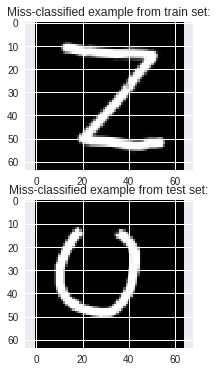

In [0]:
#### Parte 2d) Probando tu red con un modelo pre-entrenado
## Leemos los datos y los cargamos a la red:
!git clone https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile.git
os.chdir("./cc6204-DeepLearning-DCCUChile/2018/tareas/tarea1/recursos/varita_magica/")

U = torch.from_numpy(np.loadtxt("./modelos/ejemplo/U.txt")).float()
W1 = torch.from_numpy(np.loadtxt("./modelos/ejemplo/W1.txt")).float()
W2 = torch.from_numpy(np.loadtxt("./modelos/ejemplo/W2.txt")).float()
b1 = torch.from_numpy(np.loadtxt("./modelos/ejemplo/b1.txt")).float()
b2 = torch.from_numpy(np.loadtxt("./modelos/ejemplo/b2.txt")).float()
c = torch.from_numpy(np.loadtxt("./modelos/ejemplo/c.txt")).float()
trainedWeights = [W1, W2, U]
trainedBiases = [b1, b2, c]
wandNet = FFNN(64*64,[W2.size()[0],W2.size()[1]],[sig,sig],10)

wandNet.setWeights(trainedWeights)
wandNet.setBiases(trainedBiases)
wandNet.gpu()
print("MLP loaded")

## Preparación de los datos:
trainData = []
trainLabels = []
pathTrainDict = {}
c = 0
for spell in range(0, 10):
  for img in range(0, 220):
    path = "./data/train_set/hechizo-{}/{:03}.txt".format(spell, img + 1)
    pathTrainDict[str(c)] = path
    c += 1
    example = np.loadtxt(path)
    example = example.reshape(-1)
    trainData.append(example)
    label = [0] * 10
    label[spell] = 1
    trainLabels.append(label)
trainLabels = torch.Tensor(trainLabels)
trainData = torch.Tensor(trainData).float()
print("Train data loaded")

testData = []
testLabels = []
pathTestDict = {}
c = 0
for spell in range(0, 10):
  for img in range(0, 50):
    path = "./data/test_set/hechizo-{}/{:03}.txt".format(spell, img + 1)
    pathTestDict[str(c)] = path
    c += 1
    example = np.loadtxt(path)
    example = example.reshape(-1)
    testData.append(example)
    label = [0] * 10
    label[spell] = 1
    testLabels.append(label)
testLabels = torch.Tensor(testLabels)
testData = torch.Tensor(testData).float()
print("Test data loaded")

## Intentamos pasar los datos a la gpu:
try:
  trainData = trainData.cuda()
  trainLabels = trainLabels.cuda()
  testData = testData.cuda()
  testLabels = testLabels.cuda()
except Exception:
  pass

# Forward:
trainOut = wandNet.forward(trainData)
testOut = wandNet.forward(testData)

allData = torch.cat([trainData,testData],0)
allLabels = torch.cat([trainLabels,testLabels],0)
allOuts = wandNet.forward(allData)
(p, maxIndex) = torch.max(allOuts,1)
predictionMatrix = torch.zeros_like(allLabels)
wrongExamples = []
for i in range(0,allLabels.size()[0]):
  if allLabels[i][maxIndex[i]] == 1:
    predictionMatrix[i][maxIndex[i]] = 1
  else:
    wrongExamples.append(i)
correctCases = torch.mul(allLabels,predictionMatrix)
print("Accuracy over all data: {}%".format(torch.sum(correctCases)/correctCases.size()[0] * 100))

## Visualización de ejemplos mal clasificados:
trainIndex = wrongExamples[np.random.randint(0,len(wrongExamples))]
if trainIndex >= trainData.size()[0]:
  limit = trainData.size()[0]
  trainIndex = trainIndex%int(limit)
testIndex = wrongExamples[np.random.randint(0,len(wrongExamples))]
if testIndex >= testData.size()[0]:
  limit = testData.size()[0]
  testIndex = testIndex%int(limit)
trainExamplePath = pathTrainDict[str(trainIndex)].replace("txt","png")
testExamplePath = pathTestDict[str(testIndex)].replace("txt","png")
trainImage = misc.imread(trainExamplePath)
testImage = misc.imread(testExamplePath)
fig, axs = subplots(nrows=2, sharey=True, figsize=(3,2*3))
axs[0].imshow(trainImage[:, :, 1], cmap=plt.cm.gray)
axs[0].set_title("Miss-classified example from train set:")
axs[1].imshow(testImage[:, :, 1], cmap=plt.cm.gray)
axs[1].set_title("Miss-classified example from test set:")

## Checkeo de gradiente

In [0]:
#### Parte 4b) Chequeo de gradiente

## Descenso de gradiente, momentum, RMSProp y Adam


In [0]:
#### Parte 5a) Descenso de gradiente
#### Parte 7b) Descenso de gradiente con momentum
class SGD():
  def __init__(self, red, lr = 0.01, momentum = 0.9):
    self.NN = red
    self.lr = lr
    self.momentum = momentum
    self.velW = [0]*len(self.NN.Weights)
    self.velB = [0]*len(self.NN.Biases)
  
  def step(self):
    # Actualiza los parámetros a partir de los gradientes
    for layer in range(0, len(self.NN.Weights)):
      self.velW[layer] = self.momentum * self.velW[layer]- self.lr * self.NN.dL_dW[layer]
      self.velB[layer] = self.momentum * self.velB[layer]- self.lr * self.NN.dL_dB[layer]
      self.NN.Weights[layer] = self.NN.Weights[layer] + self.velW[layer]
      self.NN.Biases[layer] = self.NN.Biases[layer] + self.velB[layer]
      
  def restart(self):
    # Para reinicializar las velocidades antes de cada época
    self.velW = [0]*len(self.NN.Weights)
    self.velB = [0]*len(self.NN.Biases)

In [0]:
#### Parte 7c) RMSProp
class RMSProp():
  def __init__(self, red, lr=0.001, beta=0.9, epsilon=1e-8):
    self.NN = red
    self.lr = lr
    self.beta = beta
    self.epsilon = epsilon
    self.SW = [0]*len(self.NN.Weights)
    self.SB = [0]*len(self.NN.Biases)
  
  def step(self):
    # Actualiza los parámetros a partir de los gradientes
    for layer in range(0, len(self.NN.Weights)):
      self.SW[layer] = self.beta*self.SW[layer] + (1 - self.beta)*(self.NN.dL_dW[layer].mul(self.NN.dL_dW[layer]))
      self.SB[layer] = self.beta*self.SB[layer] + (1 - self.beta)*(self.NN.dL_dB[layer].mul(self.NN.dL_dB[layer]))
      self.NN.Weights[layer] = self.NN.Weights[layer] - (self.lr/(torch.sqrt(self.SW[layer]).add(self.epsilon))).mul(self.NN.dL_dW[layer])
      self.NN.Biases[layer] = self.NN.Biases[layer] - (self.lr/(torch.sqrt(self.SB[layer]).add(self.epsilon))).mul(self.NN.dL_dB[layer])
  
  def restart(self):
    # Para reinicializar las velocidades antes de cada época
    self.SW = [0]*len(self.NN.Weights)
    self.SB = [0]*len(self.NN.Biases)

In [0]:
#### Parte 7d) Adam
class Adam():
  def __init__(self, red, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.NN = red
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.n = 1
    self.epsilon = epsilon
    self.PW = [0]*len(self.NN.Weights)
    self.PB = [0]*len(self.NN.Biases)
    self.SW = [0]*len(self.NN.Weights)
    self.SB = [0]*len(self.NN.Biases)
  
  def step(self):
    # Actualiza los parámetros a partir de los gradientes
    for layer in range(0, len(self.NN.Weights)):
      self.PW[layer] = self.beta1*self.PW[layer] + (1 - self.beta1)*(self.NN.dL_dW[layer])
      self.PB[layer] = self.beta1*self.PB[layer] + (1 - self.beta1)*(self.NN.dL_dB[layer])
      self.SW[layer] = self.beta2*self.SW[layer] + (1 - self.beta2)*(self.NN.dL_dW[layer].mul(self.NN.dL_dW[layer]))
      self.SB[layer] = self.beta2*self.SB[layer] + (1 - self.beta2)*(self.NN.dL_dB[layer].mul(self.NN.dL_dB[layer]))
      
      PW_barra = self.PW[layer]/(1 - self.beta1**self.n)
      PB_barra = self.PB[layer]/(1 - self.beta1**self.n)
      SW_barra = self.SW[layer]/(1 - self.beta2**self.n)
      SB_barra = self.SB[layer]/(1 - self.beta2**self.n)
      
      self.NN.Weights[layer] = self.NN.Weights[layer] - (self.lr/(torch.sqrt(SW_barra).add(self.epsilon))).mul(PW_barra)
      self.NN.Biases[layer] = self.NN.Biases[layer] - (self.lr/(torch.sqrt(SB_barra).add(self.epsilon))).mul(PB_barra)
      #self.NN.Weights[layer] = self.NN.Weights[layer] - (self.lr/(torch.sqrt(SW_barra).add(self.epsilon)))*(PW_barra)
      #self.NN.Biases[layer] = self.NN.Biases[layer] - (self.lr/(torch.sqrt(SB_barra).add(self.epsilon)))*(PB_barra)
      
    self.n = self.n + 1
      
  
  def restart(self):
    # Para reinicializar las velocidades antes de cada época
    self.PW = [0]*len(self.NN.Weights)
    self.PB = [0]*len(self.NN.Biases)
    self.SW = [0]*len(self.NN.Weights)
    self.SB = [0]*len(self.NN.Biases)
    self.n = 1

## Datos random para carga


In [0]:
#### Parte 5b) Datos para carga
class RandomDataset():
  def __init__(self, N, F, C, fullyRandom = True):
    if fullyRandom: # De modo que los datos sean totalmente aleatorios
                    # Notar que se pierde cualquier relación entre datos y labels
      self.data = torch.randn(N, F)
      labels = torch.zeros(N, C)
      index = np.random.randint(0, C)
      labels[index] = 1
      self.labels = labels
    else: # Se definen los labels para los datos según alguna característica:
          # Por ejemplo, el mínimo, el máximo, el valor más cercano a algún número dado, etc...
      closestTo = torch.abs(self.data - numpy.pi/4)
      (value, index) = closestTo.min(dim = 1)
      for i in range(0, N):
        labels[i,index[i]] = 1
      self.labels = labels
  
  def __len__(self):
    return int(self.data.size()[0])
  
  def __getitem__(self, i):
    return self.data[i], self.labels[i]
  
  def paquetes(self, B):
    maxIter = int(len(self)/B)
    batch = []
    for i in range(0, maxIter):
      dataBatch = self.data[i*B:(i+1)*B]
      labelBatch = self.labels[i*B:(i+1)*B]
      batch.append([dataBatch, labelBatch])
    return batch
    

## Loop de entrenamiento

In [0]:
#### Parte 5c) Entrenando la red
def entrenar_FFNN(red, dataset, optimizador, epochs, B):
  netLoss = []
  netAccuracy = []
  for epoch in range(1, epochs+1):
    loss = 0
    accuracy = 0
    iteration = 0
    for batch, labels in dataset.paquetes(B):
      prediction = red.forward(batch)
      red.backward(batch, labels, prediction)
      optimizador.step()
      loss = loss + cross_ent_loss(prediction, labels)
      labelsIndex = torch.max(labels, 1)[1]
      predictionIndex = torch.max(prediction, 1)[1]
      rightCases = (labelsIndex == predictionIndex)
      accuracy = accuracy + rightCases.sum()/rightCases.size()[0]
      iteration = iteration + 1
    netLoss.append(loss/iteration)
    netAccuracy.append(accuracy/iteration)
    optimizador.restart()
  return red, netLoss, netAccuracy

## Entrenando con datos random y graficando la pérdida

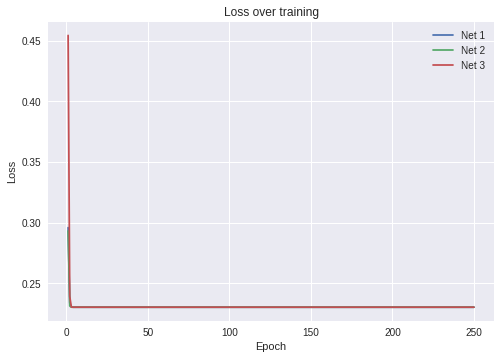

In [0]:
#### Parte 5d) Graficando la pérdida en el tiempo
F = 300; C = 10; N = 100
dataset = RandomDataset(N, F, C)

# Red 1:
Net1 = FFNN(F, [50,30], [relu, sig], C)
opt1 = SGD(Net1, 0.01)
Net1, loss1, acc1 = entrenar_FFNN(Net1, dataset, opt1, 250, 4)

# Red 2:
Net2 = FFNN(F, [15,10], [relu, sig], C)
opt2 = SGD(Net2, 0.01)
Net2, loss2, acc2 = entrenar_FFNN(Net2, dataset, opt2, 250, 4)

# Red 3:
Net3 = FFNN(F, [75,50], [relu, sig], C)
opt3 = SGD(Net3, 0.01)
Net3, loss3, acc3 = entrenar_FFNN(Net3, dataset, opt3, 250, 4)

epochs = range(1,len(loss1)+1)

plt.figure()
plt.plot(epochs, loss1, label = "Net 1")
plt.plot(epochs, loss2, label = "Net 2")
plt.plot(epochs, loss3, label = "Net 3")
plt.title("Loss over training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Entrenando con datos de varita mágica



In [0]:
#### Parte 5e) Entrenando con datos no random
class DataSet():
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
    
  def __len__(self):
    return int(self.data.size()[0])
  
  def __getitem__(self, i):
    return self.data[i], self.labels[i]
  
  def paquetes(self, B):
    maxIter = int(len(self)/B)
    batch = []
    for i in range(0, maxIter):
      dataBatch = self.data[i*B:(i+1)*B]
      labelBatch = self.labels[i*B:(i+1)*B]
      batch.append([dataBatch, labelBatch])
    return batch
  
  def shuffle(self):
    shuffle = torch.randperm(len(self))
    self.data = self.data[shuffle]
    self.labels = self.labels[shuffle]

trainData = []
trainLabels = []
pathTrainDict = {}
c = 0
for spell in range(0, 10):
  for img in range(0, 220):
    path = "./data/train_set/hechizo-{}/{:03}.txt".format(spell, img + 1)
    pathTrainDict[str(c)] = path
    c += 1
    example = np.loadtxt(path)
    example = example.reshape(-1)
    trainData.append(example)
    label = [0] * 10
    label[spell] = 1
    trainLabels.append(label)
trainLabels = torch.Tensor(trainLabels)
trainData = torch.Tensor(trainData).float()
print("Train data loaded")

testData = []
testLabels = []
pathTestDict = {}
c = 0
for spell in range(0, 10):
  for img in range(0, 50):
    path = "./data/test_set/hechizo-{}/{:03}.txt".format(spell, img + 1)
    pathTestDict[str(c)] = path
    c += 1
    example = np.loadtxt(path)
    example = example.reshape(-1)
    testData.append(example)
    label = [0] * 10
    label[spell] = 1
    testLabels.append(label)
testLabels = torch.Tensor(testLabels)
testData = torch.Tensor(testData).float()
print("Test data loaded")

# Intentamos pasar los datos a la gpu
try:
  trainData = trainData.cuda()
  trainLabels = trainLabels.cuda()
  testData = testData.cuda()
  testLabels = testLabels.cuda()
except Exception:
  pass

trainSet = DataSet(trainData, trainLabels)
testSet = DataSet(testData, testLabels)
trainSet.shuffle(); testSet.shuffle()

Train data loaded
Test data loaded


Net 1 trained
Net 2 trained
Net 3 trained
Net 4 trained


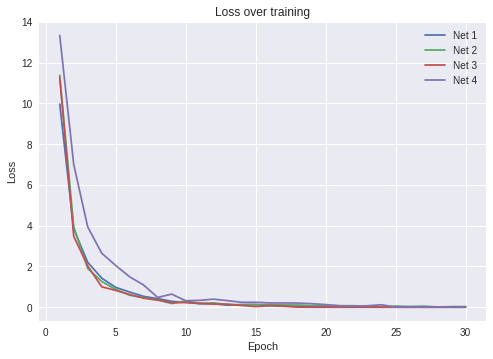

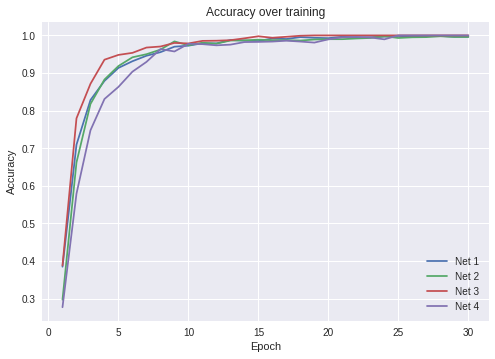

In [0]:
# Pruebas de distintas redes
F = 4096; C = 10

# Red 1:
Net1 = FFNN(F, [10,10], [relu, relu], C)
opt1 = RMSProp(Net1)
Net1, loss1, acc1 = entrenar_FFNN(Net1, trainSet, opt1, 30, 1)
print("Net 1 trained")

# Red 2:
Net2 = FFNN(F, [10,10], [relu, relu], C)
opt2 = RMSProp(Net2)
Net2, loss2, acc2 = entrenar_FFNN(Net2, trainSet, opt2, 30, 4)
print("Net 2 trained")

# Red 3:
Net3 = FFNN(F, [15,15], [relu, relu], C)
opt3 = RMSProp(Net3)
Net3, loss3, acc3 = entrenar_FFNN(Net3, trainSet, opt3, 30, 1)
print("Net 3 trained")

# Red 4:
Net4 = FFNN(F, [15,15], [relu, relu], C)
opt4 = RMSProp(Net4)
Net4, loss4, acc4 = entrenar_FFNN(Net4, trainSet, opt4, 30, 4)
print("Net 4 trained")

epochs = range(1,len(loss1)+1)

plt.figure()
plt.plot(epochs, loss1, label = "Net 1")
plt.plot(epochs, loss2, label = "Net 2")
plt.plot(epochs, loss3, label = "Net 3")
plt.plot(epochs, loss4, label = "Net 4")
plt.title("Loss over training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs, acc1, label = "Net 1")
plt.plot(epochs, acc2, label = "Net 2")
plt.plot(epochs, acc3, label = "Net 3")
plt.plot(epochs, acc4, label = "Net 4")
plt.title("Accuracy over training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Net 1 trained
Net 2 trained
Net 3 trained
Net 4 trained


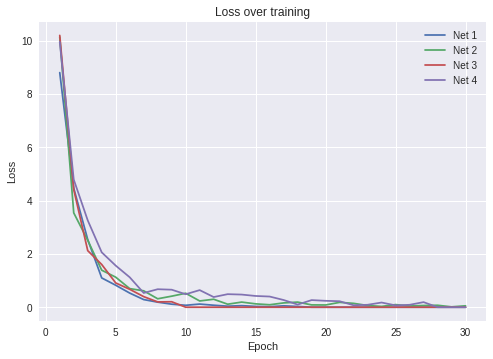

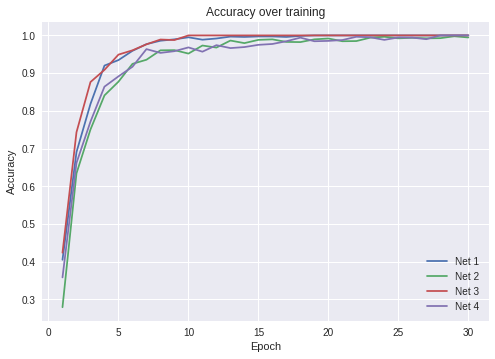

In [0]:
# Pruebas
F = 4096; C = 10

# Red 1:
Net1 = FFNN(F, [10,10], [relu, relu], C)
opt1 = Adam(Net1)
Net1, loss1, acc1 = entrenar_FFNN(Net1, trainSet, opt1, 30, 1)
print("Net 1 trained")

# Red 2:
Net2 = FFNN(F, [10,10], [relu, relu], C)
opt2 = Adam(Net2)
Net2, loss2, acc2 = entrenar_FFNN(Net2, trainSet, opt2, 30, 4)
print("Net 2 trained")

# Red 3:
Net3 = FFNN(F, [15,15], [relu, relu], C)
opt3 = Adam(Net3)
Net3, loss3, acc3 = entrenar_FFNN(Net3, trainSet, opt3, 30, 1)
print("Net 3 trained")

# Red 4:
Net4 = FFNN(F, [15,15], [relu, relu], C)
opt4 = Adam(Net4)
Net4, loss4, acc4 = entrenar_FFNN(Net4, trainSet, opt4, 30, 4)
print("Net 4 trained")


epochs = range(1,len(loss1)+1)

plt.figure()
plt.plot(epochs, loss1, label = "Net 1")
plt.plot(epochs, loss2, label = "Net 2")
plt.plot(epochs, loss3, label = "Net 3")
plt.plot(epochs, loss4, label = "Net 4")
plt.title("Loss over training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs, acc1, label = "Net 1")
plt.plot(epochs, acc2, label = "Net 2")
plt.plot(epochs, acc3, label = "Net 3")
plt.plot(epochs, acc4, label = "Net 4")
plt.title("Accuracy over training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Net 1 trained
Net 2 trained
Net 3 trained
Net 4 trained


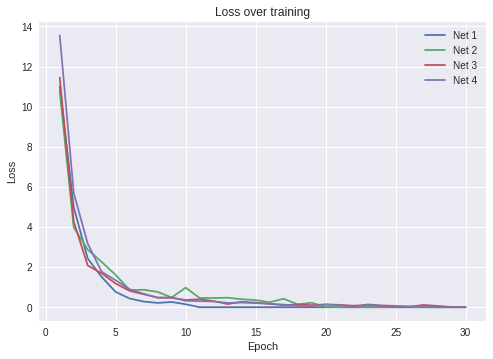

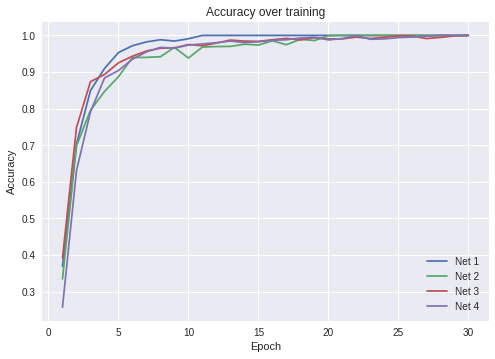

In [0]:
# Prueba para comparar RMSProp y Adam (que son los que de mejor funcionan):
F = 4096; C = 10

# Red 1:
Net1 = FFNN(F, [15,15], [relu, relu], C)
opt1 = Adam(Net1)
Net1, loss1, acc1 = entrenar_FFNN(Net1, trainSet, opt1, 30, 1)
print("Net 1 trained")

# Red 2:
Net2 = FFNN(F, [15,15], [relu, relu], C)
opt2 = Adam(Net2)
Net2, loss2, acc2 = entrenar_FFNN(Net2, trainSet, opt2, 30, 4)
print("Net 2 trained")

# Red 3:
Net3 = FFNN(F, [15,15], [relu, relu], C)
opt3 = RMSProp(Net3)
Net3, loss3, acc3 = entrenar_FFNN(Net3, trainSet, opt3, 30, 1)
print("Net 3 trained")

# Red 4:
Net4 = FFNN(F, [15,15], [relu, relu], C)
opt4 = RMSProp(Net4)
Net4, loss4, acc4 = entrenar_FFNN(Net4, trainSet, opt4, 30, 4)
print("Net 4 trained")


epochs = range(1,len(loss1)+1)

plt.figure()
plt.plot(epochs, loss1, label = "Net 1")
plt.plot(epochs, loss2, label = "Net 2")
plt.plot(epochs, loss3, label = "Net 3")
plt.plot(epochs, loss4, label = "Net 4")
plt.title("Loss over training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs, acc1, label = "Net 1")
plt.plot(epochs, acc2, label = "Net 2")
plt.plot(epochs, acc3, label = "Net 3")
plt.plot(epochs, acc4, label = "Net 4")
plt.title("Accuracy over training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Cargando datos de MNIST

Cantidad de ejemplos de entrenamiento: 60000
Cantidad de ejemplos de prueba: 10000


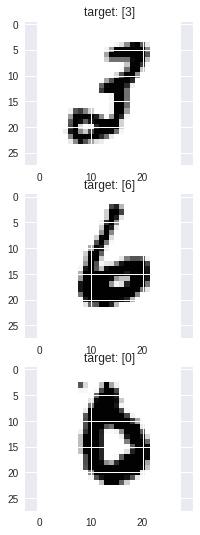

In [0]:
#### Parte 8a) Cargando y visualizando datos de MNIST

# Importamos las clases necesarias

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from matplotlib.pyplot import imshow, figure, subplots

# Descarga y almacena el conjunto de entrenamiento y prueba de MNIST
# Además aplica una transformación para convertir todas las imágenes a 
# tensores de pytroch

train_data = MNIST('mnist', train=True, download=True, transform=ToTensor())
test_data = MNIST('mnist', train=False, transform=ToTensor())

print('Cantidad de ejemplos de entrenamiento: ' + str(len(train_data)))
print('Cantidad de ejemplos de prueba: ' + str(len(test_data)))

# Muestra 3 ejemplos al azar usando un DataLoader

dataloader = DataLoader(train_data, shuffle=True)
n_ejemplos = 3

fig, axs = subplots(nrows=n_ejemplos, sharey=True, figsize=(3,n_ejemplos*3))

for i, batch in enumerate(dataloader):
  if i == n_ejemplos:
    break
    
  img, d = batch
  axs[i].set_title("target: " + str(d.numpy()))
  axs[i].imshow(img.view(28,28).numpy())

## Red neuronal para MNIST

In [0]:
#### Parte 8b) Red neuronal para MNIST

In [0]:
#### Parte 8c) Visualización de entrenamiento y convergencia

---

## Apéndice: partes a mano

### Parte 1b) Derivando las funciones de activación

### Parte 3b) Derviando la última capa

### Parte 3c) Derivando desde las capas escondidas

### Otras derivadas (derivadas opcionales de celu y swish, de batch normalization, etc.)